# Model Selection
## Explanation
**Validation** plays an important role in the choice of model, where the the model is trained on the **validation set** which is originally a part of training dataset. That is, we usually seperate our training dataset into training dataset and validation set, and we test the model with testing dataset. 

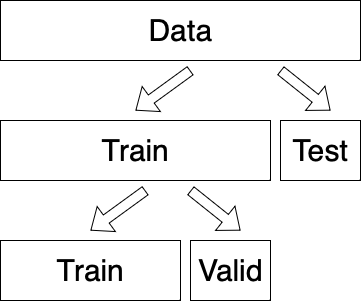

**What do we need validation**? Assume that we only have training data and testing data, and we evaluate our model with testing data. We choose the model (i.e. hyperparameter) that has the minimum testing loss. Assume that we have 3 models: Model 1, Model 2 and Model 3.

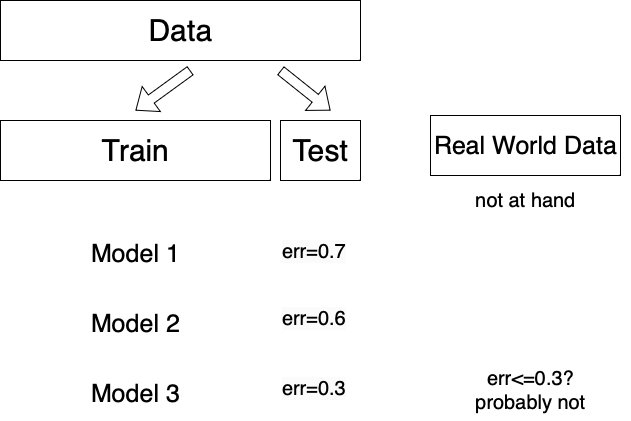
 

Recall that we hope that our model performs well on **real world data**, which is currently not at hand. Is Model 3 our best model? Probably not. Testing data is like a midterm exam, which might include hard or strange problems, but training data is just like a quiz, not too hard to learn. Thus, we might **overestimate the performance** of our model if we train on testing set. If we validate our model before testing, it's possible to improve our model. Even if we cannot improve our model, we still can evaluate it without bias.

Remember that **testing data should never be involved in model training or model selection**. Thus, we need validation set to evaluate our model so that we can select the best one.

In brief, we only need to do two things:
1. Divide our training dataset into training dataset and validation dataset.
2. Add validation step in our training loop.

We use the model and dataset in 05_CNN for our demonstration.

### PyTorch code
Normal validation

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import tqdm

In [2]:
device = 'cpu'
print(device)

cpu


In [3]:
config = {
    'n_epoch':4,
    'batch_size':64,
    'lr':0.001,
}

In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),
     transforms.Normalize((0.1307,), (0.3081,)),
])

In [5]:
train_set = torchvision.datasets.MNIST(root='./data', train=True,download=True, transform=transform)
                                
test_set = torchvision.datasets.MNIST(root='./data', train=False,download=True, transform=transform)                                       

Now we divide our `train_set` into training dataset and validation dataset. We usually set a ratio between two datasets and seperate them with `torch.utils.data.random_split`.

In [6]:
train_size = int(0.9 * len(train_set))
val_size = len(train_set) - train_size

train_set, val_set = torch.utils.data.random_split(dataset=train_set, lengths=[train_size, val_size])

In [7]:
print('train_set lenght:',len(train_set))
print('val_set length:',len(val_set))

train_set lenght: 54000
val_set length: 6000


Load our data.

In [8]:
from torch.utils.data import DataLoader

train_loader = DataLoader(dataset=train_set,batch_size=config['batch_size'],shuffle=True)
val_loader = DataLoader(dataset=val_set,batch_size=config['batch_size'],shuffle=True)
test_loader = DataLoader(dataset=test_set,batch_size=config['batch_size'],shuffle=False)

In [9]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        # input size: (28,28,1)
        self.cnn = nn.Sequential(
            nn.Conv2d(1,6,5,1,2), 
            # padding: (32,32,1)
            # after Conv2d: (6,28,28)
            nn.BatchNorm2d(6),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0), 
            # after pooling: (6,14,14)

            nn.Conv2d(6,16,5,1,0),
            # after Conv2d: (16,10,10)
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0), 
            # after pooling: (16,5,5)
        )
        self.fully_connected = nn.Sequential(
            nn.Linear(16*5*5,120),
            nn.ReLU(),
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.Linear(84, 10),
        )
    def forward(self, x):
        out = self.cnn(x)
        out = out.view(out.size()[0], -1)
        return self.fully_connected(out)

In [10]:
model = Classifier()

Preparation for saving model.

In [11]:
from pathlib import Path

MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

MODEL_NAME = "model.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME
print(MODEL_SAVE_PATH)

'''
print(MODEL_SAVE_PATH.dtype)

AttributeError: 'PosixPath' object has no attribute 'dtype'
'''

models/model.pth


"\nprint(MODEL_SAVE_PATH.dtype)\n\nAttributeError: 'PosixPath' object has no attribute 'dtype'\n"

Now we add validation to our training. Basically, validation loop is almost the same as the training loop except that we don't update our model. We need to set our model to evaluation mode with `.eval()` to disable some modules such as dropout and batch normalization. 

In [14]:
def TrainCNN():

    best_accuracy = 0.0

    model.to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=0.0003, weight_decay=1e-5) 
    criterion = nn.CrossEntropyLoss()

    train_loss = []
    train_accuracy = []

    for epoch in range(config['n_epoch']):
        # Set to train mode
        model.train()
        
        # Training loop
        
        for batch in train_loader:
            # Seperate images and lables
            imgs, labels = batch

            # Forward the images
            # Make sure your images are passed to your device

            # pred is a 10-dimensional tensor
            # The highest value is our prediction
            pred = model(imgs.to(device))

            loss = criterion(pred, labels.to(device))

            optimizer.zero_grad()

            loss.backward()

            optimizer.step()

            acc = (pred.argmax(dim=-1) == labels.to(device)).float().mean()
            
            train_loss.append(loss.item())
            train_accuracy.append(acc)

        train_loss_epoch = sum(train_loss) / len(train_loss)
        train_accuracy_epoch = sum(train_accuracy) / len(train_accuracy)


        # Validation loop
        val_loss = []
        val_accuracy = []
        model.eval() # disable dropout and batch normalization

        for batch in val_loader:
            # Seperate images and lables
            imgs, labels = batch

            pred = model(imgs.to(device))

            loss = criterion(pred, labels.to(device))
            acc = (pred.argmax(dim=-1) == labels.to(device)).float().mean()
            
            val_loss.append(loss.item())
            val_accuracy.append(acc)

        val_loss_epoch =  sum(val_loss) / len(val_loss)
        val_accuracy_epoch = sum(val_accuracy) / len(val_accuracy)

        print(f"Epoch: {epoch}| Train loss: {train_loss_epoch: .5f}| Train acc: {train_accuracy_epoch: .5f}| Val loss: {val_loss_epoch: .5f}| Val acc: {val_accuracy_epoch: .5f}")
        
        if val_accuracy_epoch>best_accuracy:            
            print("Saving model with best accuracy:",float(val_accuracy_epoch))
            torch.save(obj=model.state_dict(), f=MODEL_SAVE_PATH)
            best_accuracy = val_accuracy_epoch
        

In [15]:
TrainCNN()

Epoch: 0| Train loss:  0.05002| Train acc:  0.98494| Val loss:  0.05122| Val acc:  0.98399
Saving model with best accuracy: 0.9839870929718018
Epoch: 1| Train loss:  0.04504| Train acc:  0.98635| Val loss:  0.05010| Val acc:  0.98548
Saving model with best accuracy: 0.9854831099510193
Epoch: 2| Train loss:  0.04105| Train acc:  0.98754| Val loss:  0.04547| Val acc:  0.98648
Saving model with best accuracy: 0.9864804744720459
Epoch: 3| Train loss:  0.03786| Train acc:  0.98854| Val loss:  0.03970| Val acc:  0.98803
Saving model with best accuracy: 0.9880319237709045


Save and load our model
- `state_dict()`: a Python dictionary object that maps each layer to its learnable parameter tensor.
- `torch.save()`: saves an object to a disk file.
-  `torch.load()`: loads an object saved with torch.save() from a file.
-  `torch.load_state_dict()`: loads pretrained parameters to our model.

In [16]:
# Loading the saved model (parameters)
test_model = Classifier()
test_model.load_state_dict(torch.load(MODEL_SAVE_PATH))

<All keys matched successfully>

In testing, we no longer optimize our model. We can use `torch.inference_mode` to activate evaluation mode.

In [21]:
def Test():
    criterion = nn.CrossEntropyLoss()

    test_loss = []
    test_accuracy = []

    test_model.to(device)

    test_model.eval()
    with torch.inference_mode():     # with torch.no_grad()
        for X, y in test_loader:
            X, y = X.to(device), y.to(device)
            y_pred = test_model(X)

            test_loss.append(criterion(y_pred,y))

            acc = (y_pred.argmax(dim=-1) == y.to(device)).float().mean()
            test_accuracy.append(acc)
            
        test_loss = sum(test_loss) / len(test_loader)
        test_acc = sum(test_accuracy) / len(test_loader)

    print(f"Test loss: {test_loss: .5f}| Test acc: {test_acc: .5f}")

In [22]:
Test()

Test loss:  0.02831| Test acc:  0.98995


## K-fold cross validation
Typically, our dataset is 80/20 (or 90/10) split where 80% of dataset is for training, and 20% of dataset is for testing. One assumption behind thise method is that data is representative across the splits, which probably not holds for time-series data or strange testing data. 

K-fold cross validation serves as a good method of model selection. It provides each data division a chance to serve as both the validation and training set. For classification problems, we need to be careful that the ratio between training and validation dataset of each class should be the same. This also comes the restriction of k-fold cross validation. If our available data is in shortage, then k-fold cross validation might not be the best way.

We divide our training data into k parts, k-1 parts for training and the remaining part for validation. The loss of a model is an average of k validation losses, illustrated below.

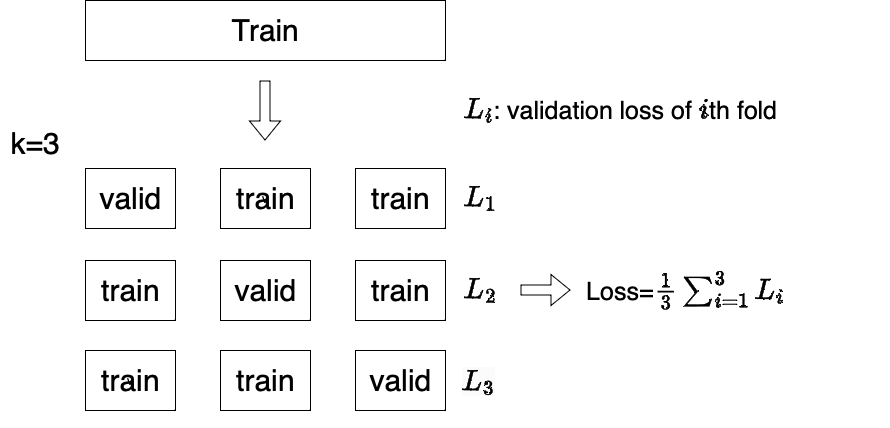

Note that k-fold cross validation may not be necessary when we use standard dataset such as MNIST or CIFAR10.

References:
- [LeNet-5 Implementation on MNIST in PyTorch](https://medium.com/@deepeshdeepakdd2/lenet-5-implementation-on-mnist-in-pytorch-c6f2ee306e37), medium 